<h1 align="center">S2R Analytics</h1>

# Table of Contents

* [1](#1): Projects
* [2](#2): Transactions
* [3](#3): Staff & teams
* [4](#4): Stages
* [5](#5): Clients 
* [6](#6): Clean-up
* [7](#7): Pre-processing

## Notebook Setup

In [1]:
# Essentials
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import numpy as np; np.random.seed(2022)
import random
import sqlite3
import pyodbc
import copy

# Image creation and display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go

# Preprocessing
from sklearn import preprocessing
from numpy import percentile
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

# Other
import itertools as it
import io
import os
os.sys.path
import sys
import glob
import concurrent.futures
from __future__ import print_function
import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import datetime, time
import functools, operator
from datetime import datetime

## 1. <a class="anchor" id="1"></a> Projects

Step 1: Create a list of projects to drop.

In [2]:
# Read all projects from Synergy API
all_projects = pd.read_csv('csv-files/wga_synergy_incremental_projects.csv')
all_projects = all_projects[['Project ID', 'Project Number', 'Project Name', 'Is Office Project', 'Is Billable', 'Project Status']]

# Projects to keep: external (i.e. client only)
external_projects = all_projects[(all_projects['Is Office Project'] != 'Yes')]
external_projects = external_projects[(external_projects['Is Billable'] != 'No')]
external_ids = external_projects['Project ID'].tolist()

# Projects to keep: status-based
successful_projects = external_projects[external_projects['Project Status'].isin(['Active']) == True]
valid_ids = successful_projects['Project ID'].tolist()

# See how many unique projects we shold have
print('We should have ' + str(len(valid_ids)) + ' projects in total.')

We should have 2414 projects in total.


In [3]:
print('Hence, ' + str(len(all_projects) - len(valid_ids)) + ' projects were dropped for being invalid.')

Hence, 12911 projects were dropped for being invalid.


Step 2: Cleaning data from Synergy API.

In [4]:
# Load only valid projects
api_projects = pd.read_csv('csv-files/wga_synergy_incremental_projects.csv', parse_dates=['Start Date (Project)', 'End Date (Project)'], dayfirst=True)
api_projects = (api_projects[api_projects['Project ID'].isin(valid_ids)])


# Drop unnecesary columns
api_projects.drop(columns = ['Unnamed: 0', 'Primary Contact Name', 'Status Name', 'Organisation ID',
                             'customFields', 'Address Line 1', 'Address Line 2', 'Project Type ID',
                             'Primary Contact', 'Primary Contact ID', 'Project Scope', 'Address Postal Code',
                             'Address State', 'Address Town', 'Address Google', 'Client Reference Number',
                             'Address State Postal Code Country', 'Address Single Line', 'Project Type Code',
                             'External Name', 'Address Longitude', 'Address Latitude', 'Project Manager', 
                             'Project Forecast Value', 'Created Date', 'Updated Date'], inplace = True)


# Convert columns for unified style
api_projects.rename(columns = {'Invoices':'Number of Invoices', 'Project Net Residual (Neg as Zero)':'Project Net Residual',
                              'Start Date (Project)': 'Project Start Date', 'End Date (Project)': 'Project End Date',
                              'Address Country':'Country', 'Project Type': 'Sector'}, inplace = True)
api_projects['Country'].replace(['AUSTRALIA', 'AUS', 'Autralia', 'NZ', 'new zealand', 'PNG', 'samoa', 'SAMOA', 'TONGA', 'SA', 'CHINA'],
                                ['Australia', 'Australia', 'Australia', 'New Zealand', 'New Zealand', 'Papua New Guinea', 'Samoa', 'Samoa', 'Tonga', 'Saudi Arabia', 'China'],inplace=True)


# Generalise minority observations into bigger groups
api_projects['Sector'].mask(api_projects['Sector'] == 'Commercial', 'Commercial & Retail Buildings', inplace=True)
api_projects['Sector'].mask(api_projects['Sector'] == 'Residential', 'Civic & Education Buildings', inplace=True)
api_projects['Default Rate Group'].mask(api_projects['Default Rate Group'] != 'Standard', 'Non-standard', inplace=True)


# Adding 'Due Date' and'Project Director' columns
custom_fields = pd.read_csv('csv-files/wga_synergy_incremental_projects_custom_fields.csv')
custom_fields = custom_fields[['PROPOSAL - Due Date', 'PROSPECT - Project Director', 'Project ID']].copy()
custom_fields.rename(columns = {'PROSPECT - Project Director':'Project Director', 'PROPOSAL - Due Date': 'Due Date'}, inplace = True)
custom_fields['Project Director'] = custom_fields['Project Director'].str.rstrip(' (MPD)')
custom_fields['Due Date'] = pd.to_datetime(custom_fields['Due Date'])
api_projects = pd.merge(api_projects, custom_fields,  how='left', on='Project ID')


# Rearrange column names for easier interpretation
api_projects = api_projects[['Project ID', 'Country',
                             'Project Status', 'Sector',
                             'Project Director', 'Manager ID', 'Office',
                             'Project Start Date', 'Project End Date', 'Due Date']]

len(api_projects)

2414

Step 3: Cleaning transformed PowerBI data from S2R Analytics.

In [5]:
# Read the pre-transformed data from PowerBI
pbi_projects = pd.read_csv('csv-files/wga_power_bi_projects.csv', encoding = 'ISO-8859-1', low_memory=False)
pbi_projects = pbi_projects[['Project ID', 'Project Size Sort Order', 'Is Multi Discipline Project','Is First Client Project']]

# Load only valid projects
pbi_projects = (pbi_projects[pbi_projects['Project ID'].isin(valid_ids)])

# Convert columns for unified style
pbi_projects['Is Multi Discipline Project'].replace(['No', 'Yes'],[False, True],inplace=True)
pbi_projects['Is First Client Project'].replace(['No', 'Yes'],[False, True],inplace=True)

# Convert the object column to boolean
pbi_projects['Is Multi Discipline Project'] = pbi_projects['Is Multi Discipline Project'].astype(bool)
pbi_projects['Is Multi Discipline Project'] = pbi_projects['Is Multi Discipline Project'].astype(int)
pbi_projects['Is First Client Project'] = pbi_projects['Is First Client Project'].astype(int)

len(pbi_projects)

2413

Step 4: Merge the two 'Projects' tables together.

In [6]:
# Merge the projects table from API and preprocesed Power BI table
projects = pd.merge(api_projects, pbi_projects,  how='left', left_on='Project ID', right_on='Project ID')
projects.columns = projects.columns.str.replace(' ', '_')
projects.head(1)

,Project_ID,Country,Project_Status,Sector,Project_Director,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project
0,367711,Australia,Active,Civic & Education Buildings,Loreto Taglienti,7612773,WGASA Pty Ltd,2020-08-01,2022-08-01,NaT,4.0,1.0,1.0


## 2. <a class="anchor" id="2"></a> Transactions

### 2.1 <a class="anchor" id="2.1"></a> Data cleaning

In [7]:
# Read only valid projects' transactions from Synergy API.
transactions = pd.read_csv('csv-files/wga_sql_transactions.csv', parse_dates=['date'], dayfirst=True, low_memory=False)
transactions = (transactions[transactions['projectId'].isin(valid_ids)])

transactions = transactions[['id', 'projectId', 'stageId', 'staffId', 'transactionTypeId',
                             'rateType', 'status','units',
                             'invoiceValueTotal','actualCostTotal', 'date']]

transactions.rename(columns = {'id':'Transaction ID', 'projectId':'Project ID',
                                'staffId':'Staff ID',
                               'transactionTypeId': 'Transaction Type',
                               'rateType': 'Rate Type', 'status': 'Status',
                               'stageId': 'Stage ID', 'date':'Date',
                               'invoiceValueTotal': 'Invoice Value Total',
                               'actualCostTotal':'Actual Cost Total',
                               'units': 'Units'}, inplace = True)

transactions = transactions[(transactions['Status'] == 'Invoiced') | (transactions['Status'] == 'Written off')]
transactions['Transaction Type'].replace([100, 200, 300, 400, 500, 700, 750, 800],
                                         ['Time', 'Cash', 'Travel', 'Office', 'Bill', 'Balance', 'Unearned', 'Invoice Custom'], inplace=True)
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions.columns = transactions.columns.str.replace(' ', '_')
transactions = transactions[['Project_ID', 'Staff_ID', 'Transaction_Type', 'Invoice_Value_Total', 'Actual_Cost_Total',  'Units', 'Rate_Type', 'Date']]
transactions = transactions[(transactions['Transaction_Type'] == 'Time') | (transactions['Transaction_Type'] == 'Bill')]

recorded_invoice = transactions.loc[transactions['Invoice_Value_Total'] != 0.0]
recorded_invoice_ids = recorded_invoice['Project_ID'].tolist()
transactions = (transactions[transactions['Project_ID'].isin(recorded_invoice_ids)])

print('Only ' + str(transactions['Project_ID'].nunique()) + ' projects have transaction recorded, meaning ' + str(len(projects) - transactions['Project_ID'].nunique()) + ' projects will be missing from transaction table.')
transactions.reset_index(inplace=True, drop=True)
transactions

Only 2178 projects have transaction recorded, meaning 236 projects will be missing from transaction table.


,Project_ID,Staff_ID,Transaction_Type,Invoice_Value_Total,Actual_Cost_Total,Units,Rate_Type,Date
0,375028,7612841.0,Time,491.33,360.7350,1.50,Staff,2021-08-26
1,375028,7612841.0,Time,491.33,360.7350,1.50,Staff,2021-08-30
2,375028,7612841.0,Time,491.33,360.7350,1.50,Staff,2021-08-31
3,375028,7612841.0,Time,81.89,60.1225,0.25,Staff,2021-08-02
4,375028,7612841.0,Time,982.66,721.4700,3.00,Staff,2021-08-11
...,...,...,...,...,...,...,...,...
508294,954191,7612780.0,Time,655.83,750.3500,2.50,Staff,2021-09-07
508295,954191,7612780.0,Time,131.17,150.0700,0.50,Staff,2021-09-14
508296,954191,7612780.0,Time,131.17,150.0700,0.50,Staff,2021-09-01
508297,954191,7612780.0,Time,262.33,300.1400,1.00,Staff,2021-09-03


### 2.2 <a class="anchor" id="2.2"></a> Creating and investigating profit margins

In [8]:
# Profit_Margin
df_8 = pd.DataFrame(transactions.groupby(['Project_ID'])[['Invoice_Value_Total', 'Actual_Cost_Total']].sum()).reset_index()
df_8['Profit_Margin'] = (df_8['Invoice_Value_Total'] - df_8['Actual_Cost_Total'])/ df_8['Invoice_Value_Total']
df_8['Profit_Margin'] = df_8['Profit_Margin'].astype('float')
print('Profit margins vary between ' + str(df_8['Profit_Margin'].min()) + ' and ' + str(df_8['Profit_Margin'].max()) + '.')

Profit margins vary between -65.4729691226713 and 0.9431920428462127.


In [9]:
lowest = df_8.loc[df_8['Profit_Margin'] == df_8['Profit_Margin'].min()]
lowest

,Project_ID,Invoice_Value_Total,Actual_Cost_Total,Profit_Margin
275,368864,1551.3,103119.517,-65.472969


In [10]:
positives = df_8.loc[df_8['Profit_Margin'] > 0]
print('There are ' + str(len(positives)) + ' projects with profit margin higher than 0.')
negatives = df_8.loc[df_8['Profit_Margin'] < 0]
print('There are ' + str(len(negatives)) + ' projects with profit margin lower than 0.')
zeros = df_8.loc[df_8['Profit_Margin'] == 0]
print('There are ' + str(len(zeros)) + ' projects with profit margin equal to 0.')

There are 1721 projects with profit margin higher than 0.
There are 454 projects with profit margin lower than 0.
There are 3 projects with profit margin equal to 0.


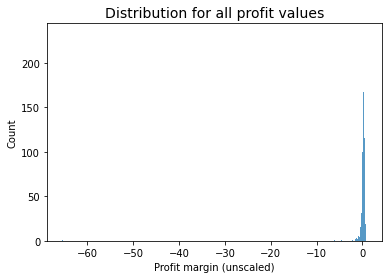

In [11]:
# No scaling with outliers
ax = plt.gca()
sns.histplot(df_8['Profit_Margin'], linewidth=0)
plt.xlabel('Profit margin (unscaled)')
plt.title('Distribution for all profit values', size=14)
plt.show()

In [12]:
df_8['Profit_Margin'].quantile([0.25, 0.75], interpolation='nearest')

0.25    0.048276
0.75    0.357608
Name: Profit_Margin, dtype: float64

In [13]:
# Calculate the minimum and maximum bounds aside outliers
q1 = 0.048276
q3 = 0.357608
minimum = q1 - 1.5*(q3-q1)
maximum = q3 + 1.5*(q3-q1)

print('Minimum is ', str(minimum), '\nMaximum is ', str(maximum), '\nMedium is ', str(df_8['Profit_Margin'].median()))

Minimum is  -0.41572200000000004 
Maximum is  0.8216060000000001 
Medium is  0.24293451536514804


In [14]:
seed(1)
q25, q75 = percentile(df_8['Profit_Margin'], 25), percentile(df_8['Profit_Margin'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
all_outliers = [x for x in df_8['Profit_Margin'] if x < lower or x > upper]
print('All outliers: %d' % len(all_outliers))
lower_outliers = [x for x in df_8['Profit_Margin'] if x < lower]
print('Lower outliers: %d' % len(lower_outliers))
outliers_removed = [x for x in df_8['Profit_Margin'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=0.049, 75th=0.358, IQR=0.309
All outliers: 109
Lower outliers: 108
Non-outlier observations: 2069


In [15]:
lower_outliers = [x for x in df_8['Profit_Margin'] if x < lower]
print('Lower outliers: %d' % len(lower_outliers))

Lower outliers: 108


In [16]:
redefined_lower_outliers = [x for x in df_8['Profit_Margin'] if x < -0.8216060000000001]
print('Redefined lower outliers: %d' % len(redefined_lower_outliers))

Redefined lower outliers: 44


In [17]:
df_8 = df_8[(df_8['Profit_Margin'] >= -0.8216060000000001) & (df_8['Profit_Margin'] <= 0.8216060000000001)]
df_8

,Project_ID,Invoice_Value_Total,Actual_Cost_Total,Profit_Margin
0,367711,30875.00,2.626771e+04,0.149224
1,367721,2137508.96,1.175295e+06,0.450157
2,367723,67649.75,7.292045e+04,-0.077912
3,367725,2187823.75,1.621559e+06,0.258826
4,367729,2642831.05,1.485188e+06,0.438032
...,...,...,...,...
2173,1464521,12287.50,7.345420e+03,0.402204
2174,1471658,962.50,7.483000e+02,0.222545
2175,1473765,1175.00,8.133550e+02,0.307783
2176,1473924,875.00,5.633550e+02,0.356166


In [18]:
print('Profit margins vary between ' + str(df_8['Profit_Margin'].min()) + ' and ' + str(df_8['Profit_Margin'].max()) + '.')

Profit margins vary between -0.7957991666666667 and 0.8093464282361776.


In [19]:
# Add the 'Profit_Margin' to the 'Projects' table
projects = pd.merge(df_8, projects, how='left', on='Project_ID')
projects.drop(['Invoice_Value_Total', 'Actual_Cost_Total'], axis=1, inplace = True)

In [20]:
profit_class = {}
for pr in df_8['Profit_Margin']:
  if pr < 0:
    profit_class[pr] = 0  # negative profitability
  elif pr > 0.3:
    profit_class[pr] = 2 # good profitability
  else:
    profit_class[pr] = 1 # low profitability

In [21]:
pr_class_df = pd.DataFrame([{'Profit_Margin': pr, 'Profit_Class': profit_class} for (pr, profit_class) in profit_class.items()])
pr_class_df

,Profit_Margin,Profit_Class
0,0.149224,1
1,0.450157,2
2,-0.077912,0
3,0.258826,1
4,0.438032,2
...,...,...
2117,0.357054,2
2118,0.402204,2
2119,0.222545,1
2120,0.307783,2


In [22]:
df_9 = pd.merge(projects, pr_class_df,  how='left', on='Profit_Margin')

In [23]:
df_9['Profit_Class'].value_counts()

1    921
2    802
0    410
Name: Profit_Class, dtype: int64

In [24]:
profit_bins = pd.DataFrame({'categories': ['negative', 'low', 'good'],
                              'project_count': [410, 802, 921]})

Text(0.5, 0, 'Profitability category')

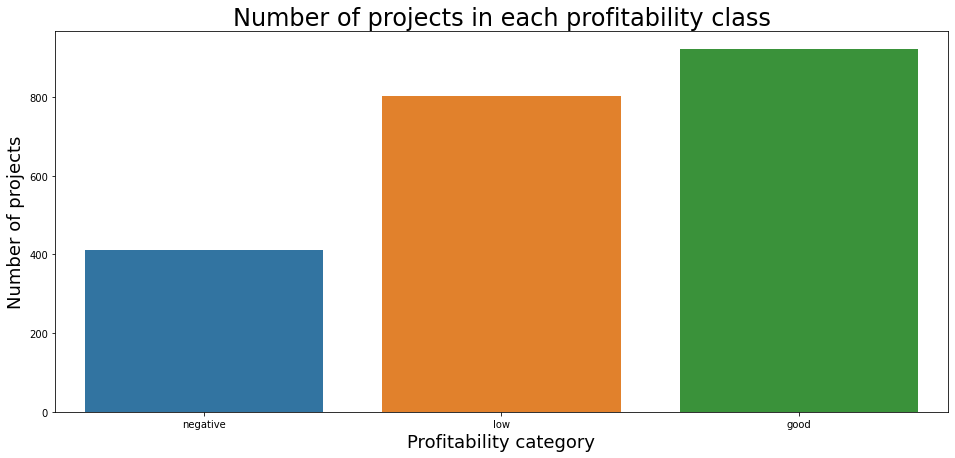

In [25]:
plt.figure(figsize=(16,7))
ax = sns.barplot(x = 'categories', y = 'project_count', data = profit_bins)
plt.title('Number of projects in each profitability class', fontsize=24)
plt.ylabel('Number of projects', fontsize=18)
plt.xlabel('Profitability category', fontsize=18)

In [26]:
df_9 = df_9[['Project_ID', 'Profit_Class']]
projects = pd.merge(projects, df_9, how='left', on='Project_ID')
projects

,Project_ID,Profit_Margin,Country,Project_Status,Sector,Project_Director,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Profit_Class
0,367711,0.149224,Australia,Active,Civic & Education Buildings,Loreto Taglienti,7612773,WGASA Pty Ltd,2020-08-01,2022-08-01,NaT,4.0,1.0,1.0,1
1,367721,0.450157,Australia,Active,Urban development,Damien Byrne,7612926,WGASA Pty Ltd,2015-05-01,2021-11-30,NaT,8.0,1.0,1.0,2
2,367723,-0.077912,Australia,Active,Ports & Marine,Mark Gilbert,7612709,WGASA Pty Ltd,2021-09-02,2022-06-30,NaT,5.0,1.0,1.0,0
3,367725,0.258826,Australia,Active,Urban development,Damien Byrne,7612827,WGASA Pty Ltd,2015-06-01,2021-12-20,NaT,8.0,1.0,1.0,1
4,367729,0.438032,Australia,Active,Urban development,Damien Byrne,7612730,WGASA Pty Ltd,2015-05-01,2022-12-20,NaT,8.0,1.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128,1464521,0.402204,Australia,Active,Civic & Education Buildings,David McKay,7613204,WGASA Pty Ltd,2022-03-28,2022-05-15,2022-01-20,3.0,0.0,0.0,2
2129,1471658,0.222545,Australia,Active,Urban development,Nathan Silby,7612838,WGASA Pty Ltd,2022-03-30,2022-03-30,NaT,1.0,0.0,0.0,1
2130,1473765,0.307783,Australia,Active,Energy,Cameron Jackson,7612860,WGAVIC Pty Ltd,2022-03-31,2022-04-20,NaT,1.0,0.0,0.0,2
2131,1473924,0.356166,Australia,Active,Energy,Cameron Jackson,7612860,WGAVIC Pty Ltd,2022-03-31,2022-04-29,NaT,1.0,0.0,0.0,2


### 2.3 <a class="anchor" id="2.3"></a> Creating other transaction-based features

Perc_of_Subcontractors = 
* total units of subcontractors divided by
* sum of units where transaction type is 'bill' or 'time'

* 'Time' = Company's employees
* 'Bill' = Hired subcontrators
* Time + Bill = total human capital on project in hours

In [27]:
# Perc_of_Subcontractors
subs = transactions[['Project_ID', 'Units', 'Rate_Type', 'Transaction_Type']]
subs = subs[(subs['Rate_Type'] == 'Subcontractor')]
subs.drop(columns = ['Rate_Type'], inplace = True)
subs = pd.DataFrame(subs.groupby(['Project_ID'])['Units'].sum()).reset_index()
subs.rename(columns = {'Units': 'Sub_Hours_Per_Project'}, inplace = True)

total_hours = transactions[['Project_ID', 'Units', 'Transaction_Type']]
total_hours = total_hours[(total_hours['Transaction_Type'] == 'Time') | (total_hours['Transaction_Type'] == 'Bill')]
total_hours = pd.DataFrame(total_hours.groupby(['Project_ID'])['Units'].sum()).reset_index()
total_hours.rename(columns = {'Units': 'Total_Hours_Per_Project'}, inplace = True)

df_1 = pd.merge(projects, subs, how='left', on='Project_ID')
df_1['Sub_Hours_Per_Project'].fillna(0, inplace=True)
df_2 = pd.merge(df_1, total_hours, how='left', on='Project_ID')
df_2['Total_Hours_Per_Project'].fillna(0, inplace=True)
df_2['Sub_Hours_Per_Project'].isnull().sum(), df_2['Total_Hours_Per_Project'].isnull().sum()
df_2['Perc_of_Subcontractors'] = (df_2['Sub_Hours_Per_Project']/df_2['Total_Hours_Per_Project']).round(decimals = 2)*100
df_2 = df_2[['Project_ID', 'Perc_of_Subcontractors']]

# Add the new feature to the 'Projects' table
projects = pd.merge(projects, df_2,  how='left', on='Project_ID')
len(projects)

2133

In [28]:
# Project_Start_Date, Project_End_Date

def nat_check(date):
    if type(date) == pd._libs.tslibs.nattype.NaTType:
        return True
    else:
        return False

min_dates =  pd.DataFrame(transactions.groupby(['Project_ID'])['Date'].min()).reset_index()
min_dates.rename(columns = {'Date':'Min_Date'}, inplace = True)
max_dates =  pd.DataFrame(transactions.groupby(['Project_ID'])['Date'].max()).reset_index()
max_dates.rename(columns = {'Date':'Max_Date'}, inplace = True)
all_dates = pd.merge(min_dates, max_dates, how='left', on='Project_ID')
projects = pd.merge(projects, all_dates, how='left', on='Project_ID')
len(projects)

2133

In [29]:
projects['Project_Start_Date'] = projects['Project_Start_Date'].map(str)
projects['Project_End_Date'] = projects['Project_End_Date'].map(str)
projects['Due_Date'] = projects['Due_Date'].map(str)

projects.loc[projects['Project_Start_Date']=='NaT','Project_Start_Date']=projects['Min_Date']
projects.loc[projects['Project_End_Date']=='NaT','Project_End_Date']=projects['Max_Date']
projects.loc[projects['Due_Date']=='NaT','Due_Date']=projects['Max_Date']

projects['Project_Start_Date'] = pd.to_datetime(projects['Project_Start_Date'])
projects['Project_End_Date'] = pd.to_datetime(projects['Project_End_Date'])
projects['Due_Date'] = pd.to_datetime(projects['Due_Date'])

projects.drop(columns = ['Min_Date', 'Max_Date'], inplace = True)
len(projects)

2133

Now, let's go back to engieering date-dependent features with newly filled in values in the 'Projects' table.

In [30]:
# Project_Duration_Weeks
projects['Project_Duration_Weeks'] = (projects['Project_End_Date'] - projects['Project_Start_Date']).astype('timedelta64[W]')
neg_weeks = projects[(projects['Project_Duration_Weeks'] < 0)]
neg_ids = neg_weeks['Project_ID'].tolist()
neg_weeks = (projects[projects['Project_ID'].isin(neg_ids)])
neg_weeks

,Project_ID,Profit_Margin,Country,Project_Status,Sector,Project_Director,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Profit_Class,Perc_of_Subcontractors,Project_Duration_Weeks


In [31]:
# Manually substitute those dates that don't make sense from transactions to created and updates dates from the opriginal API table.
projects.loc[projects['Project_ID'] == 376189, 'Project_Start_Date'] = pd.to_datetime('13/08/2019')
projects.loc[projects['Project_ID'] == 376189, 'Project_End_Date'] = pd.to_datetime('25/02/2020')

projects.loc[projects['Project_ID'] == 1311624, 'Project_Start_Date'] = pd.to_datetime('07/12/2021')
projects.loc[projects['Project_ID'] == 1311624, 'Project_End_Date'] = pd.to_datetime('24/01/2022')

In [32]:
projects['Project_Duration_Weeks'] = (projects['Project_End_Date'] - projects['Project_Start_Date']).astype('timedelta64[W]')
neg_weeks = projects[(projects['Project_Duration_Weeks'] < 0)]
neg_ids = neg_weeks['Project_ID'].tolist()
neg_weeks = (projects[projects['Project_ID'].isin(neg_ids)])
neg_weeks

,Project_ID,Profit_Margin,Country,Project_Status,Sector,Project_Director,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Profit_Class,Perc_of_Subcontractors,Project_Duration_Weeks


## 3. <a class="anchor" id="3"></a> Staff & teams

This section resulted in *aec.staff* table in RDS for Client X.

In [33]:
active = pd.read_csv('csv-files/wga_synergy_overnight_1_staff.csv', parse_dates=['Employment Date'], dayfirst=True)
active = active[['Staff ID', 'Staff Name', 'Employment Date', 'Synergy Team']]
active['Employment Date'] = pd.to_datetime(active['Employment Date'])
active['Employment Months'] = ((datetime.now() - active['Employment Date']).astype('timedelta64[M]'))
active.columns = active.columns.str.replace(' ', '_')

leavers = pd.read_csv('csv-files/wga_synergy_overnight_1_staff_-_leavers.csv', parse_dates=['Employment Date', 'Termination Date'], dayfirst=True)
leavers = leavers[['Staff ID', 'Staff Name', 'Employment Date', 'Termination Date', 'Synergy Team']]
leavers['Employment Date'] = pd.to_datetime(leavers['Employment Date'])
leavers['Termination Date'] = pd.to_datetime(leavers['Termination Date'])
leavers['Employment Months'] = ((leavers['Termination Date'] - leavers['Employment Date']).astype('timedelta64[M]'))
leavers.columns = leavers.columns.str.replace(' ', '_')

staff = pd.concat([active, leavers], axis = 0, ignore_index = True) # axis=0 specifies vertical stacking
staff = staff[['Staff_ID', 'Staff_Name', 'Synergy_Team', 'Employment_Months', 'Employment_Date', 'Termination_Date']]
staff

,Staff_ID,Staff_Name,Synergy_Team,Employment_Months,Employment_Date,Termination_Date
0,7612683,Mel Chittleborough,SA - Finance,264.0,2000-09-25,NaT
1,7612686,Andrew Woods,SA - Buildings,437.0,1986-04-25,NaT
2,7612687,Adam Fairhead,SA - Buildings,200.0,2006-01-08,NaT
3,7612688,Alex Granegger Carneiro,SA - Buildings,252.0,2001-09-17,NaT
4,7612691,Alex Lloyd,SA - Civil,178.0,2007-11-12,NaT
...,...,...,...,...,...,...
820,10019349,Tori Davidson,SA - Industrial,1.0,2022-02-01,2022-03-18
821,10053476,Delete Delete,WA - Structural,0.0,2022-01-01,2022-01-01
822,10069064,Rianna Radocchia,WA - Project Delivery Services,1.0,2022-03-14,2022-05-06
823,10077594,Michael Salib,WA - Project Delivery Services,0.0,2022-04-26,2022-04-26


**8 features to engineer and move them all to 'Projects' table:**
* Director_Empl_Months 
* Manager_Empl_Months
* Manager_Is_Recent
* Director_Is_Recent
<br>
<br>
* Team_Size
* Perc_Team_Recent
* Is_Multi_Team
* Num_Teams_Involved

In [34]:
# Director_Is_Recent, Director_Empl_Months

directors = projects[['Project_ID', 'Project_Director', 'Project_Start_Date']]
directors = pd.merge(directors, staff, how='left', left_on='Project_Director', right_on='Staff_Name')
directors.rename(columns = {'Synergy_Team':'Director_Team', 'Employment_Months':'Director_Empl_Months'}, inplace = True)
directors['Months_Before_Project'] = (directors['Project_Start_Date'] - directors['Employment_Date']).astype('timedelta64[M]')
directors.drop(columns = ['Staff_Name', 'Project_Start_Date'], inplace = True)

Director_Is_Recent = {}

for months in directors['Months_Before_Project']:
    if np.isnan(months) == True:
        continue
    else:
        if months < 6:
            Director_Is_Recent[months] = True
        else:
            Director_Is_Recent[months] = False
        
df_13 = pd.DataFrame([{'Months_Before_Project': months, 'Director_Is_Recent': recent_status} for (months, recent_status) in Director_Is_Recent.items()])

directors = pd.merge(directors, df_13, how ='left', on='Months_Before_Project')
directors.drop(columns = ['Employment_Date', 'Termination_Date', 'Months_Before_Project'], inplace = True)
projects = pd.merge(projects, directors, how ='left', on=['Project_ID', 'Project_Director'])
projects.rename(columns = {'Staff_ID':'Director_ID'}, inplace = True)
projects.drop(columns = 'Project_Director', inplace = True)
len(projects)

2133

In [35]:
# Manager_Is_Recent, Manager_Empl_Months

managers = projects[['Project_ID', 'Manager_ID', 'Project_Start_Date']]
managers = pd.merge(managers, staff, how='left', left_on='Manager_ID', right_on='Staff_ID')
managers.rename(columns = {'Synergy_Team':'Manager_Team', 'Employment_Months':'Manager_Empl_Months'}, inplace = True)
managers['Months_Before_Project'] = (managers['Project_Start_Date'] - managers['Employment_Date']).astype('timedelta64[M]')
managers.drop(columns = ['Staff_ID', 'Staff_Name', 'Project_Start_Date'], inplace = True)  

Manager_Is_Recent = {}

for months in managers['Months_Before_Project']:
    if np.isnan(months) == True:
        continue
    else:
        if months < 6:
            Manager_Is_Recent[months] = True
        else:
            Manager_Is_Recent[months] = False
        
df_14 = pd.DataFrame([{'Months_Before_Project': months, 'Manager_Is_Recent': recent_status} for (months, recent_status) in Manager_Is_Recent.items()])

managers = pd.merge(managers, df_14, how ='left', on='Months_Before_Project')
managers = managers[['Project_ID', 'Manager_ID', 'Manager_Team', 'Manager_Empl_Months', 'Manager_Is_Recent']]

projects = pd.merge(projects, managers, how ='left', on=['Project_ID', 'Manager_ID'])
len(projects)

2133

In [36]:
type(staff['Staff_ID'][0])

numpy.int64

In [37]:
type(transactions['Staff_ID'][0])

numpy.float64

In [38]:
nulls = pd.DataFrame(transactions['Staff_ID'].isnull())
nulls.rename(columns = {'Staff_ID':'checker'}, inplace = True)
nulls = nulls.loc[nulls['checker'] == True]
unrecorded_staff_ids = list(nulls.index.values)
nulls = transactions.iloc[unrecorded_staff_ids]
nulls

,Project_ID,Staff_ID,Transaction_Type,Invoice_Value_Total,Actual_Cost_Total,Units,Rate_Type,Date
27,809464,NaN,Bill,1762.0,1762.00,1.0,Supplier,2021-08-18
28,809464,NaN,Bill,327.5,327.50,1.0,Supplier,2021-08-16
84,938929,NaN,Bill,0.0,220.00,1.0,Supplier,2021-07-11
238,756003,NaN,Bill,0.0,170.45,1.0,Supplier,2021-06-01
615,1120088,NaN,Bill,997.5,997.50,1.0,Supplier,2021-08-23
...,...,...,...,...,...,...,...,...
507435,371828,NaN,Bill,2880.0,2688.00,1.0,Supplier,2022-04-01
507436,371828,NaN,Bill,1980.0,1848.00,1.0,Supplier,2022-04-01
507797,971525,NaN,Bill,600.0,600.00,1.0,Supplier,2022-04-01
508188,768790,NaN,Bill,0.0,600.00,1.0,Supplier,2022-04-01


In [39]:
len(unrecorded_staff_ids)

10264

In [40]:
len(transactions) - len(unrecorded_staff_ids)

498035

In [41]:
transactions = transactions.drop(index=unrecorded_staff_ids)
len(transactions)

498035

In [42]:
transactions['Staff_ID'] = (transactions['Staff_ID'].astype('int64'))
teams = pd.merge(transactions, staff, how='left', on='Staff_ID')
len(projects) - teams['Project_ID'].nunique()

-26

In [43]:
# Num_Teams_Involved
df_16 = pd.DataFrame(teams.groupby(['Project_ID'])['Synergy_Team'].nunique()).reset_index()
df_16.rename(columns = {'Synergy_Team':'Num_Teams_Involved'}, inplace = True)

# Is_Multi_Team
df_16['Is_Multi_Team'] = (df_16['Num_Teams_Involved'] > 1)
df_16['Is_Multi_Team'].value_counts()

# Add 'Num_Teams_Involved' and 'Is_Multi_Team' to the 'Projects' table. Missing values will be accounted for in part 8 (pre-processing).
projects = pd.merge(projects, df_16, how='left', on='Project_ID')

In [44]:
# Team_Size
df_17 = pd.DataFrame(teams.groupby(['Project_ID'])['Staff_ID'].nunique()).reset_index()
df_17.rename(columns = {'Staff_ID':'Team_Size'}, inplace = True)
projects = pd.merge(projects, df_17, how='left', on='Project_ID')

In [45]:
# Perc_of_Team_Recent
pr_start_dates = pd.DataFrame(projects[['Project_ID', 'Project_Start_Date']])
recency = pd.DataFrame(teams[['Project_ID', 'Staff_ID', 'Employment_Date']])
recency.drop_duplicates(inplace = True, ignore_index=True)
df_19 = pd.merge(recency, pr_start_dates, how='left', on='Project_ID')
df_19['Months_Before_Project'] = (df_19['Project_Start_Date'] - df_19['Employment_Date']).astype('timedelta64[M]')
df_19 = df_19[['Project_ID', 'Staff_ID', 'Months_Before_Project']]
teams = pd.merge(teams, df_19, how ='left', on=['Project_ID', 'Staff_ID'])

Staff_Is_Recent = {}

for months in df_19['Months_Before_Project']:
    if np.isnan(months) == True:
        continue
    else:
        if months < 6:
            Staff_Is_Recent[months] = True
        else:
            Staff_Is_Recent[months] = False
        
df_20 = pd.DataFrame([{'Months_Before_Project': months, 'Staff_Is_Recent': recency_status} for (months, recency_status) in Staff_Is_Recent.items()])

df_21 = pd.merge(teams, df_20, how='left', on='Months_Before_Project')
df_21 = df_21[['Project_ID', 'Staff_ID', 'Staff_Is_Recent']]
df_21['Staff_Is_Recent'] = df_21['Staff_Is_Recent']*1
df_22 = pd.DataFrame(df_21.groupby(['Project_ID'])['Staff_Is_Recent'].sum()).reset_index()
df_22.rename(columns = {'Staff_Is_Recent':'Num_of_Recent_Staff'}, inplace = True)

df_23 = pd.merge(df_17, df_22, how='left', on='Project_ID')
df_23['Num_of_Recent_Staff'] = df_23['Num_of_Recent_Staff'].astype(int)
df_23['Perc_of_Team_Recent'] = ((df_23['Num_of_Recent_Staff'] / df_23['Team_Size'])*100).round(decimals = 2)
df_23 = df_23[['Project_ID', 'Perc_of_Team_Recent']]

projects = pd.merge(projects, df_23, how='left', on='Project_ID')
projects.head(1)

,Project_ID,Profit_Margin,Country,Project_Status,Sector,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Profit_Class,Perc_of_Subcontractors,Project_Duration_Weeks,Director_ID,Director_Team,Director_Empl_Months,Director_Is_Recent,Manager_Team,Manager_Empl_Months,Manager_Is_Recent,Num_Teams_Involved,Is_Multi_Team,Team_Size,Perc_of_Team_Recent
0,367711,0.149224,Australia,Active,Civic & Education Buildings,7612773,WGASA Pty Ltd,2020-08-01,2022-08-01,2021-06-15,4.0,1.0,1.0,1,0.0,104.0,7612768,SA - Buildings,340.0,False,SA - Buildings,320.0,False,2.0,True,11.0,0.0


## 4. <a class="anchor" id="4"></a> Stages

This section resulted in *aec.stages* table in RDS for Client X.

In [46]:
# Read only valid projects' stages
stages = pd.read_csv('csv-files/wga_power_bi_stages.csv', encoding = 'ISO-8859-1', low_memory=False)
stages = (stages[stages['Project ID'].isin(valid_ids)])
stages = stages[(stages['Stage Type'] != 'Proposal')] # We only want professional fees
stages = stages[['Project ID', 'Stage ID', 'Stage Fee Type', 'Is Disbursement Stage',
                 'Stage Manager', 'Stage Discipline','Stage Start Date','Stage End Date']]

stages['Is Disbursement Stage'].replace(['No', 'Yes'], [False, True],inplace=True)
stages['Stage Start Date'] = pd.to_datetime(stages['Stage Start Date'])
stages['Stage End Date'] = pd.to_datetime(stages['Stage End Date'])
stages.columns = stages.columns.str.replace(' ', '_')
stages.drop(columns = 'Is_Disbursement_Stage', axis=1, inplace = True)
stages.head(1)

,Project_ID,Stage_ID,Stage_Fee_Type,Stage_Manager,Stage_Discipline,Stage_Start_Date,Stage_End_Date
373,369081,1400047,Hourly rates,Rick Penfold,Design,NaT,NaT


In [47]:
stages['Project_ID'].nunique()

2413

**1 feature to engineer:**
* Perc_of_Stages_with_Hourly_Rates

In [48]:
# Perc_of_Stages_with_Hourly_Rates
df_9 = pd.DataFrame(stages.groupby(['Project_ID', 'Stage_Fee_Type'])['Stage_ID'].count()).reset_index()
df_10 = pd.DataFrame(stages.groupby(['Project_ID'])['Stage_Fee_Type'].count()).reset_index()
df_10.rename(columns = {'Stage_Fee_Type':'Total_Num_Stages'}, inplace = True)
df_10 = pd.merge(df_9, df_10, how='left', on='Project_ID')
df_10.rename(columns = {'Stage_ID':'Num_of_Stages_Per_Type'}, inplace = True)
df_11 = df_10[(df_10['Stage_Fee_Type'] == 'Hourly rates')]
df_11['Perc_of_Stages_with_Hourly_Rates'] = ((df_11['Num_of_Stages_Per_Type'] / df_11['Total_Num_Stages'])*100).round(decimals = 2)
df_11 = df_11[['Project_ID', 'Perc_of_Stages_with_Hourly_Rates']]
df_12 = pd.merge(stages, df_11, how='left', on='Project_ID')
df_12['Perc_of_Stages_with_Hourly_Rates'] = df_12['Perc_of_Stages_with_Hourly_Rates'].fillna(0)
df_12 = df_12[['Project_ID', 'Perc_of_Stages_with_Hourly_Rates']].copy()
df_12.drop_duplicates(inplace = True, ignore_index=True)
projects = pd.merge(projects, df_12,  how ='left', on ='Project_ID')
projects

C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_3720\1982791734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_11['Perc_of_Stages_with_Hourly_Rates'] = ((df_11['Num_of_Stages_Per_Type'] / df_11['Total_Num_Stages'])*100).round(decimals = 2)


,Project_ID,Profit_Margin,Country,Project_Status,Sector,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Profit_Class,Perc_of_Subcontractors,Project_Duration_Weeks,Director_ID,Director_Team,Director_Empl_Months,Director_Is_Recent,Manager_Team,Manager_Empl_Months,Manager_Is_Recent,Num_Teams_Involved,Is_Multi_Team,Team_Size,Perc_of_Team_Recent,Perc_of_Stages_with_Hourly_Rates
0,367711,0.149224,Australia,Active,Civic & Education Buildings,7612773,WGASA Pty Ltd,2020-08-01,2022-08-01,2021-06-15,4.0,1.0,1.0,1,0.0,104.0,7612768,SA - Buildings,340.0,False,SA - Buildings,320.0,False,2.0,True,11.0,0.00,100.00
1,367721,0.450157,Australia,Active,Urban development,7612926,WGASA Pty Ltd,2015-05-01,2021-11-30,2022-03-29,8.0,1.0,1.0,2,0.0,343.0,7612730,SA - Civil,200.0,False,SA - Civil,87.0,True,3.0,True,68.0,2326.47,45.56
2,367723,-0.077912,Australia,Active,Ports & Marine,7612709,WGASA Pty Ltd,2021-09-02,2022-06-30,2021-01-31,5.0,1.0,1.0,0,0.0,43.0,7612709,SA - Industrial,434.0,False,SA - Industrial,434.0,False,5.0,True,16.0,0.00,75.00
3,367725,0.258826,Australia,Active,Urban development,7612827,WGASA Pty Ltd,2015-06-01,2021-12-20,2022-04-22,8.0,1.0,1.0,1,0.0,342.0,7612730,SA - Civil,200.0,False,SA - Civil,140.0,False,6.0,True,91.0,1861.54,44.33
4,367729,0.438032,Australia,Active,Urban development,7612730,WGASA Pty Ltd,2015-05-01,2022-12-20,2022-03-31,8.0,1.0,1.0,2,0.0,398.0,7612730,SA - Civil,200.0,False,SA - Civil,200.0,False,8.0,True,92.0,1972.83,28.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128,1464521,0.402204,Australia,Active,Civic & Education Buildings,7613204,WGASA Pty Ltd,2022-03-28,2022-05-15,2022-01-20,3.0,0.0,0.0,2,0.0,6.0,7612852,SA - Industrial,128.0,False,SA - Industrial,38.0,False,1.0,False,3.0,0.00,50.00
2129,1471658,0.222545,Australia,Active,Urban development,7612838,WGASA Pty Ltd,2022-03-30,2022-03-30,2022-03-30,1.0,0.0,0.0,1,0.0,0.0,7612781,Group - Support Services,199.0,False,SA - Civil,136.0,False,1.0,False,1.0,0.00,100.00
2130,1473765,0.307783,Australia,Active,Energy,7612860,WGAVIC Pty Ltd,2022-03-31,2022-04-20,2022-04-07,1.0,0.0,0.0,2,0.0,2.0,7612841,VIC - Support Services,290.0,False,VIC - Buildings,171.0,False,1.0,False,1.0,0.00,0.00
2131,1473924,0.356166,Australia,Active,Energy,7612860,WGAVIC Pty Ltd,2022-03-31,2022-04-29,2022-04-01,1.0,0.0,0.0,2,0.0,4.0,7612841,VIC - Support Services,290.0,False,VIC - Buildings,171.0,False,1.0,False,1.0,0.00,0.00


In [49]:
# Stage_Duration_Weeks
df_4 = pd.DataFrame(stages['Stage_Start_Date'].notnull() & stages['Stage_End_Date'].notnull())
df_4.rename(columns = {0:'checker'}, inplace = True)
df_4 = df_4.loc[df_4['checker'] == True]

stages = pd.merge(stages, df_4, left_index=True, right_index=True)
stages['Stage_Duration_Weeks'] = ((stages['Stage_End_Date'] - stages['Stage_Start_Date']).astype('timedelta64[W]'))
stages.drop(columns = 'checker', inplace = True)

## 5. <a class="anchor" id="5"></a> Clients

This section resulted in *aec.clients* table in RDS for Client X.

Step 1: Cleaning all given data, from Synergy API and Power BI.

In [50]:
# Step 1: Cleaning data from Synergy API.
api_clients = pd.read_csv('csv-files/wga_synergy_overnight_1_clients.csv')
api_clients.drop(columns = {'Client Name', 'Unnamed: 0', 'Contact Type', 'Organisation ID'}, inplace = True)
api_clients['Created Date'] = pd.to_datetime(api_clients['Created Date'])

# Step 2: Cleaning transformed PowerBI data from S2R Analytics.
pbi_clients = pd.read_csv('csv-files/wga_power_bi_clients.csv', encoding = 'ISO-8859-1')
pbi_clients = pbi_clients[['Client ID', 'Client Projects - Total No', 'Client Projects - First Project ID']]
pbi_clients.rename(columns = {'Client Projects - Total No': 'Client Projects Total No',
                              'Client Projects - First Project ID':'1st Project ID'}, inplace = True)

# Step 3: Merge the two 'Clients' tables together.
clients = pd.merge(api_clients, pbi_clients,  how='left', left_on='Client ID', right_on='Client ID')
clients.columns = clients.columns.str.replace(' ', '_')
clients.head(1)

,Client_ID,Created_Date,Client_Projects_Total_No,1st_Project_ID
0,10317738,2022-05-06,NaN,NaN


In [51]:
clients['Client_ID'].nunique()

12306

**3 features to engineer:**
* Client_Duration_Months
* Client_Is_Repeated
* Client_Is_Recent

In [52]:
# Client_Is_Repeated
clients['Client_Is_Repeated'] = clients['1st_Project_ID'].notnull()

# Client_Duration_Months
clients['Client_Duration_Months'] = datetime.now() - clients['Created_Date']
clients['Client_Duration_Months'] = (clients['Client_Duration_Months'].astype('timedelta64[M]'))
clients['Client_Duration_Months'].isnull().sum()

0

In [53]:
# Client_Is_Recent

Client_Is_Recent = {}

for months in clients['Client_Duration_Months']:
    if months < 6:
        Client_Is_Recent[months] = True
    else:
        Client_Is_Recent[months] = False
         
df_12 = pd.DataFrame(
    [{'Client_Duration_Months': months, 'Client_Is_Recent': recent_status} for (months, recent_status) in Client_Is_Recent.items()])

clients = pd.merge(clients, df_12, how='left', on='Client_Duration_Months')
clients.head(1)

,Client_ID,Created_Date,Client_Projects_Total_No,1st_Project_ID,Client_Is_Repeated,Client_Duration_Months,Client_Is_Recent
0,10317738,2022-05-06,NaN,NaN,False,4.0,True


## 6. <a class="anchor" id="6"></a> Clean-up

In [54]:
projects.columns

Index(['Project_ID', 'Profit_Margin', 'Country', 'Project_Status', 'Sector',
       'Manager_ID', 'Office', 'Project_Start_Date', 'Project_End_Date',
       'Due_Date', 'Project_Size_Sort_Order', 'Is_Multi_Discipline_Project',
       'Is_First_Client_Project', 'Profit_Class', 'Perc_of_Subcontractors',
       'Project_Duration_Weeks', 'Director_ID', 'Director_Team',
       'Director_Empl_Months', 'Director_Is_Recent', 'Manager_Team',
       'Manager_Empl_Months', 'Manager_Is_Recent', 'Num_Teams_Involved',
       'Is_Multi_Team', 'Team_Size', 'Perc_of_Team_Recent',
       'Perc_of_Stages_with_Hourly_Rates'],
      dtype='object')

In [55]:
len(projects.columns)

28

In [57]:
# Drop columns unnecessary for analysis and rearrange
projects = projects[['Project_ID', 'Country', 'Office', 'Sector',
       'Project_Size_Sort_Order', 'Is_Multi_Discipline_Project',
       'Is_Multi_Team', 'Num_Teams_Involved', 'Team_Size', 'Perc_of_Team_Recent',
       'Is_First_Client_Project', 'Perc_of_Subcontractors',
       'Project_Duration_Weeks', 'Director_Is_Recent', 'Manager_Is_Recent',
        'Perc_of_Stages_with_Hourly_Rates', 'Profit_Class']]

len(projects.columns)

17

Dropped 11 columns: Project Status, Manager ID, Director ID, Manager Team, Director Team, Project Start Date, Project End Date, Due Date, Director Employment Months, Manager Employment Months, Profit Margin.

## 7. <a class="anchor" id="7"></a> Pre-processing

### 7.1 <a class="anchor" id="7_1"></a> Missing values

In [58]:
df = copy.deepcopy(projects)
cols = df.columns[df.isnull().any()].to_list()

for c in cols:
    print(c, df[c].isnull().sum())

Country 46
Is_Multi_Team 19
Num_Teams_Involved 19
Team_Size 19
Perc_of_Team_Recent 19


In [59]:
df['Country'].fillna(df['Country'].value_counts().idxmax(), inplace = True)

In [60]:
nulls = pd.DataFrame(df['Is_Multi_Team'].isnull())
nulls.rename(columns = {'Is_Multi_Team':'checker'}, inplace = True)
nulls = nulls.loc[nulls['checker'] == True]
unrecorded_teams = list(nulls.index.values)
nulls = df.iloc[unrecorded_teams]
nulls

,Project_ID,Country,Office,Sector,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_Multi_Team,Num_Teams_Involved,Team_Size,Perc_of_Team_Recent,Is_First_Client_Project,Perc_of_Subcontractors,Project_Duration_Weeks,Director_Is_Recent,Manager_Is_Recent,Perc_of_Stages_with_Hourly_Rates,Profit_Class
792,429681,Australia,WGASA Pty Ltd,Defence & Space,8.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,106.0,False,False,0.0,0
794,429685,Australia,WGASA Pty Ltd,Defence & Space,7.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,17.0,False,False,0.0,1
795,429691,Australia,WGASA Pty Ltd,Defence & Space,7.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,16.0,False,False,0.0,1
1101,719490,Australia,WGASA Pty Ltd,Defence & Space,6.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,78.0,False,True,0.0,0
1130,733269,Australia,WGASA Pty Ltd,Defence & Space,6.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,60.0,False,False,0.0,1
1131,733309,Australia,WGASA Pty Ltd,Defence & Space,7.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,77.0,False,False,0.0,0
1145,751425,Australia,WGASA Pty Ltd,Defence & Space,6.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,75.0,False,True,0.0,1
1147,751625,Australia,WGASA Pty Ltd,Ports & Marine,6.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,21.0,False,False,50.0,1
1180,789442,Australia,WGASA Pty Ltd,Defence & Space,6.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,82.0,False,True,0.0,1
1181,789444,Australia,WGASA Pty Ltd,Defence & Space,7.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,82.0,False,True,0.0,0


In [61]:
null_ids = nulls['Project_ID'].tolist()

In [62]:
teams.loc[teams['Project_ID'].isin([null_ids])]

,Project_ID,Staff_ID,Transaction_Type,Invoice_Value_Total,Actual_Cost_Total,Units,Rate_Type,Date,Staff_Name,Synergy_Team,Employment_Months,Employment_Date,Termination_Date,Months_Before_Project


In [63]:
df['Is_Multi_Team'] = df['Is_Multi_Team'].fillna(0)
df['Num_Teams_Involved'] = df['Num_Teams_Involved'].fillna(0)
df['Team_Size'] = df['Team_Size'].fillna(0)
df['Perc_of_Team_Recent'] = df['Perc_of_Team_Recent'].fillna(100)

In [64]:
missing = df.loc[df['Project_ID'].isin(null_ids)]
missing['Director_Is_Recent'] = df['Director_Is_Recent'].replace([False],True)
missing['Manager_Is_Recent'] = df['Manager_Is_Recent'].replace([False],True)
missing

C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_3720\2672041771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['Director_Is_Recent'] = df['Director_Is_Recent'].replace([False],True)
C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_3720\2672041771.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['Manager_Is_Recent'] = df['Manager_Is_Recent'].replace([False],True)


,Project_ID,Country,Office,Sector,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_Multi_Team,Num_Teams_Involved,Team_Size,Perc_of_Team_Recent,Is_First_Client_Project,Perc_of_Subcontractors,Project_Duration_Weeks,Director_Is_Recent,Manager_Is_Recent,Perc_of_Stages_with_Hourly_Rates,Profit_Class
792,429681,Australia,WGASA Pty Ltd,Defence & Space,8.0,0.0,0,0.0,0.0,100.0,0.0,0.0,106.0,True,True,0.0,0
794,429685,Australia,WGASA Pty Ltd,Defence & Space,7.0,0.0,0,0.0,0.0,100.0,0.0,0.0,17.0,True,True,0.0,1
795,429691,Australia,WGASA Pty Ltd,Defence & Space,7.0,0.0,0,0.0,0.0,100.0,0.0,0.0,16.0,True,True,0.0,1
1101,719490,Australia,WGASA Pty Ltd,Defence & Space,6.0,0.0,0,0.0,0.0,100.0,0.0,0.0,78.0,True,True,0.0,0
1130,733269,Australia,WGASA Pty Ltd,Defence & Space,6.0,0.0,0,0.0,0.0,100.0,0.0,0.0,60.0,True,True,0.0,1
1131,733309,Australia,WGASA Pty Ltd,Defence & Space,7.0,0.0,0,0.0,0.0,100.0,0.0,0.0,77.0,True,True,0.0,0
1145,751425,Australia,WGASA Pty Ltd,Defence & Space,6.0,0.0,0,0.0,0.0,100.0,0.0,0.0,75.0,True,True,0.0,1
1147,751625,Australia,WGASA Pty Ltd,Ports & Marine,6.0,0.0,0,0.0,0.0,100.0,0.0,0.0,21.0,True,True,50.0,1
1180,789442,Australia,WGASA Pty Ltd,Defence & Space,6.0,0.0,0,0.0,0.0,100.0,0.0,0.0,82.0,True,True,0.0,1
1181,789444,Australia,WGASA Pty Ltd,Defence & Space,7.0,0.0,0,0.0,0.0,100.0,0.0,0.0,82.0,True,True,0.0,0


In [65]:
missing_teams = list(missing.index.values)
df.drop(missing_teams, axis=0, inplace=True)
len(df)

2114

In [66]:
df.loc[df['Project_ID'].isin([null_ids])]

,Project_ID,Country,Office,Sector,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_Multi_Team,Num_Teams_Involved,Team_Size,Perc_of_Team_Recent,Is_First_Client_Project,Perc_of_Subcontractors,Project_Duration_Weeks,Director_Is_Recent,Manager_Is_Recent,Perc_of_Stages_with_Hourly_Rates,Profit_Class


In [67]:
full = pd.concat([df,missing], ignore_index=True)
len(full)

2133

In [68]:
# Verify changes
df.isnull().sum()

Project_ID                          0
Country                             0
Office                              0
Sector                              0
Project_Size_Sort_Order             0
Is_Multi_Discipline_Project         0
Is_Multi_Team                       0
Num_Teams_Involved                  0
Team_Size                           0
Perc_of_Team_Recent                 0
Is_First_Client_Project             0
Perc_of_Subcontractors              0
Project_Duration_Weeks              0
Director_Is_Recent                  0
Manager_Is_Recent                   0
Perc_of_Stages_with_Hourly_Rates    0
Profit_Class                        0
dtype: int64

### 7.2 <a class="anchor" id="7_2"></a> Conversion

In [69]:
df = copy.deepcopy(full)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Project_ID                        2133 non-null   int64  
 1   Country                           2133 non-null   object 
 2   Office                            2133 non-null   object 
 3   Sector                            2133 non-null   object 
 4   Project_Size_Sort_Order           2133 non-null   float64
 5   Is_Multi_Discipline_Project       2133 non-null   float64
 6   Is_Multi_Team                     2133 non-null   object 
 7   Num_Teams_Involved                2133 non-null   float64
 8   Team_Size                         2133 non-null   float64
 9   Perc_of_Team_Recent               2133 non-null   float64
 10  Is_First_Client_Project           2133 non-null   float64
 11  Perc_of_Subcontractors            2133 non-null   float64
 12  Projec

In [70]:
# Convert the object column to boolean or integer where appropriate
df['Is_Multi_Discipline_Project'] = df['Is_Multi_Discipline_Project'].astype(bool)
df['Is_Multi_Team'] = df['Is_Multi_Team'].astype(bool)
df['Is_First_Client_Project'] = df['Is_First_Client_Project'].astype(bool)
df['Team_Size'] = df['Team_Size'].astype(int)

### 7.3 <a class="anchor" id="7_3"></a> Label encoding

In [72]:
le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])
df['Office'] = le.fit_transform(df['Office'])
df['Sector'] = le.fit_transform(df['Sector'])

df['Is_Multi_Discipline_Project'] = df['Is_Multi_Discipline_Project']*1
df['Is_Multi_Team'] = df['Is_Multi_Team']*1
df['Is_First_Client_Project'] = df['Is_First_Client_Project']*1
df['Director_Is_Recent'] = df['Director_Is_Recent']*1
df['Manager_Is_Recent'] = df['Manager_Is_Recent']*1

### 7.4 <a class="anchor" id="7_4"></a> Dealing with multicollinearity

In [73]:
df.columns = df.columns.str.replace('_', ' ')
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif_info['Column'] = df.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
2,15.877825,Office
4,9.595047,Project Size Sort Order
7,9.523908,Num Teams Involved
0,8.356458,Project ID
8,6.139432,Team Size
6,4.783846,Is Multi Team
16,3.456990,Profit Class
3,2.975305,Sector
5,2.763192,Is Multi Discipline Project
15,2.626303,Perc of Stages with Hourly Rates


In [74]:
X = df.drop(['Num Teams Involved'], axis = 1).copy()

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
2,13.914569,Office
4,9.558999,Project Size Sort Order
0,8.224649,Project ID
7,4.124929,Team Size
6,4.109190,Is Multi Team
15,3.440640,Profit Class
3,2.956799,Sector
5,2.762228,Is Multi Discipline Project
14,2.626183,Perc of Stages with Hourly Rates
11,2.418720,Project Duration Weeks


In [75]:
df.drop(['Num Teams Involved'], axis = 1, inplace = True)

In [76]:
len(df.columns), len(X.columns)

(16, 16)

In [77]:
# Save the final dataframes in CSV format
df.to_csv('csv-files/active_projects.csv', index=False)